[View in Colaboratory](https://colab.research.google.com/github/chokkan/deeplearningclass/blob/master/mnist.ipynb)

# Neural Networks on MNIST

This Jupyter notebook explains various approaches for implementing neural networks that recognize digits on [MNIST](http://yann.lecun.com/exdb/mnist/) dataset.

## Preparing the MNIST dataset

Most deep learning frameworks provide APIs for loading famous datasets like MNIST (e.g., `torchvision.datasets.MNIST` in pytorch). The APIs are handy, but hide the important step for preparing a training data for a deep learning framework; when graduating from an example dataset to the real data, we must convert a training data of our interest into the data structure that is acceptable by a deep learning framework.

The cell below downloads the original distribution of the MNIST dataset on the Web, converts the dataset into `numpy` arrays, and saves the arrays as the file `mnist.npz` with keyword names.

In [0]:
import gzip
import os
import sys
import struct
import numpy as np

def read_image(fi):
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n*rows*columns)
    return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0

def read_label(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)

if __name__ == '__main__':
    os.system('wget -N http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz')
    
    np.savez_compressed(
        'mnist',
        train_x=read_image(gzip.open('train-images-idx3-ubyte.gz', 'rb')),
        train_y=read_label(gzip.open('train-labels-idx1-ubyte.gz', 'rb')),
        test_x=read_image(gzip.open('t10k-images-idx3-ubyte.gz', 'rb')),
        test_y=read_label(gzip.open('t10k-labels-idx1-ubyte.gz', 'rb'))
    )

The file contains four numpy arrays (one tensor and array for each split of training and test sets) with the keywords:

+ `train_x`: $60000 \text{ (images)} \times 28 \text{ (y)} \times 28 \text{ (x)}$
+ `train_y`: $60000 \text{ (labels)}$
+ `test_x`: $10000 \text{ (images)} \times 28 \text{ (y)} \times 28 \text{ (x)}$
+ `test_y`: $10000 \text{ (labels)}$


In [60]:
import numpy as np
data = np.load('mnist.npz')

print(data['train_x'].shape, data['train_x'].dtype)
print(data['train_y'].shape, data['train_y'].dtype)
print(data['test_x'].shape, data['test_x'].dtype)
print(data['test_y'].shape, data['test_y'].dtype)

(60000, 28, 28) float32
(60000,) uint8
(10000, 28, 28) float32
(10000,) uint8


## Visualize the dataset

## Perceptron algorithm for single-layer neural network

5


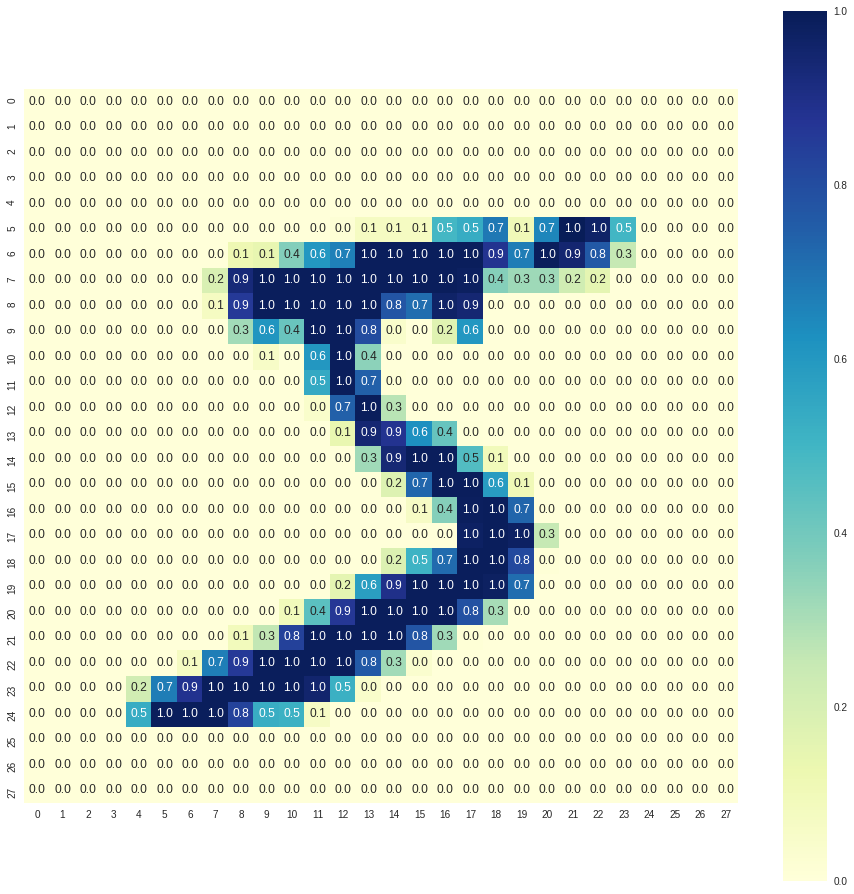

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Index number of an instance (change this to view another instance).
i = 0

data = np.load('mnist.npz')
image = data['train_x'][i]
label = data['train_y'][i]

print(label)
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(image, annot=True, fmt='.1f', square=True, cmap="YlGnBu")
plt.show()

In [0]:
PF = {}

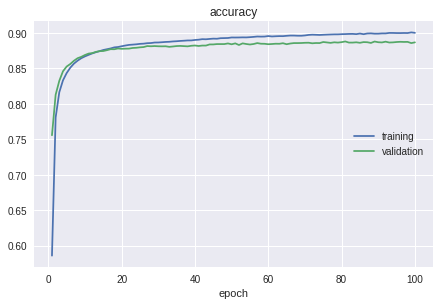

In [167]:
import numpy as np
from livelossplot import PlotLosses

def image_to_vector(X):
    X = np.reshape(X, (len(X), -1))     # Flatten: (N x 28 x 28) -> (N x 784)
    return np.c_[X, np.ones(len(X))]    # Append 1: (N x 784) -> (N x 785)

data = np.load('mnist.npz')
Xtrain = image_to_vector(data['train_x'])
Ytrain = data['train_y']
Xtest = image_to_vector(data['test_x'])
Ytest = data['test_y']

W = np.random.randn(10, 28*28+1)

liveloss = PlotLosses()
eta = 0.001
for t in range(100):
    # Structured perceptron for updating weights.
    num_correct_train = 0
    for x, y in zip(Xtrain, Ytrain):
        y_pred = np.argmax(np.dot(W, x))
        if y_pred != y:
            W[y] += x * eta
            W[y_pred] -= x * eta
        else:
            num_correct_train += 1

    # Evaluate and store the accuracy on the test set.
    num_correct_test = 0
    for x, y in zip(Xtest, Ytest):
        y_pred = np.argmax(np.dot(W, x))
        if y_pred == y:
            num_correct_test += 1
    
    liveloss.update({
        'accuracy': float(num_correct_train) / len(Ytrain),
        'val_accuracy': float(num_correct_test) / len(Ytest)
    })
    liveloss.draw()

## Stochastic gradient descent for single-layer neural network

In [130]:
import numpy as np

def softmax(x):
    # Result of softmax are inveriant even if we add/subtract a constant.
    ex = np.exp(x - np.max(x))  # Subtract such that the maximum value is one.
    return ex / ex.sum(axis=0)

def image_to_vector(X):
    X = np.reshape(X, (len(X), -1))     # Flatten: (N x 28 x 28) -> (N x 784)
    return np.c_[X, np.ones(len(X))]    # Append 1: (N x 784) -> (N x 785)

def label_to_onehot(Y, K):
    return np.eye(K)[Y]              # e.g., 3 -> [0, 0, 0, 1, 0, 0, 0, 0, 0]
    
data = np.load('mnist.npz')
Xtrain = image_to_vector(data['train_x'])
Ytrain = label_to_onehot(data['train_y'], 10)
Xtest = image_to_vector(data['test_x'])
Ytest = data['test_y']

W = np.random.randn(10, 28*28+1)

P = []
eta = 0.001
for t in range(100):
    # Stochastic gradient descent.
    for x, y in zip(Xtrain, Ytrain):
        y_pred = softmax(np.dot(W, x))
        W += np.outer(eta * (y - y_pred), x)
    
    # Evaluate and store the accuracy on the test set.
    num_correct = 0
    for x, y in zip(Xtest, Ytest):
        y_pred = np.argmax(np.dot(W, x))
        if y_pred == y:
            num_correct += 1
    P.append(num_correct / len(Ytest))

PF['SGD (numpy; constant eta)'] = P
print(P[-1])

0.917


## Training with pytorch

### Install pytorch

In [68]:
!pip install torch torchvision

    100% |████████████████████████████████| 484.0MB 27kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5af9e000 @  0x7f16d89231c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 16.2MB/s 
    100% |████████████████████████████████| 2.0MB 2.3MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


### Convert the numpy arrays into pytorch tensor

In [0]:
def create_dataset(x, y, flatten=False):
    if flatten:
        # Convert it into a matrix (N [samples], 28*28 [dims])
        xt = torch.from_numpy(x).view(len(x), -1)
    else:
        # Convert it into a 4D tensor (N [samples], 1 [ch], 28 [px], 28 [px])
        xt = torch.from_numpy(x).unsqueeze(1)
    yt = torch.from_numpy(y).long()
    return TensorDataset(xt, yt)

def validate_model(model, test_loader, device):
    model.eval()

    num_correct = 0
    for batch_idx, (x, y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        _, predicted = torch.max(y_pred.data, 1)
        num_correct += (predicted == y).sum()

    model.train()
    return float(num_correct) / len(test_loader.dataset)

### Single-layer neural network

In [135]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

#device = torch.device("cpu") # Uncomment this to run on CPU
device = torch.device("cuda:0") # Uncomment this to run on GPU

data = np.load('mnist.npz')

# Convert the data (numpy arrays) into TensorDataset.
train_set = create_dataset(data['train_x'], data['train_y'], flatten=True)
test_set = create_dataset(data['test_x'], data['test_y'], flatten=True)

# Define a neural network as a sequence of modules.
model = nn.Sequential()
model.add_module('fc1', nn.Linear(784, 10, bias=True))
print(model)
model.to(device)

# Corss-entropy loss.
loss_fn = nn.CrossEntropyLoss(size_average=False)

# Optimizer based on SGD.
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Sampler for instances (with mini-batch support).
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128)

P = []
for t in range(100):
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)   # Transfer to GPU if necessary.
        y_pred = model(x)                   # Make predictions.
        loss = loss_fn(y_pred, y)           # Compute the loss.

        optimizer.zero_grad()       # Zero-clear gradients.
        loss.backward()             # Compute the gradients.
        optimizer.step()            # Update the parameters using the gradients.
        
    # Evaluate and store the accuracy on the test set.
    P.append(validate_model(model, test_loader, device))
    #print(t+1, P[-1])

PF['Single-layer (pytorch)'] = P
print(P[-1])

Sequential(
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)
0.9264


In [136]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

#device = torch.device("cpu") # Uncomment this to run on CPU
device = torch.device("cuda:0") # Uncomment this to run on GPU

data = np.load('mnist.npz')

# Convert the data (numpy arrays) into TensorDataset.
train_set = create_dataset(data['train_x'], data['train_y'], flatten=True)
test_set = create_dataset(data['test_x'], data['test_y'], flatten=True)

# Define a neural network as a sequence of modules.
model = nn.Sequential()
model.add_module('fc1',      nn.Linear(784, 256))
model.add_module('relu1',    nn.ReLU())
model.add_module('dropout1', nn.Dropout())
model.add_module('fc2',      nn.Linear(256, 256))
model.add_module('relu2',    nn.ReLU())
model.add_module('dropout2', nn.Dropout())
model.add_module('fc3',      nn.Linear(256, 10))
print(model)
model.to(device)

# Corss-entropy loss.
loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

# Optimizer based on SGD (change "SGD" to "Adam" to use Adam)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128)

P = []
for t in range(100):
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)   # Transfer to GPU if necessary.
        y_pred = model(x)                   # Make predictions.
        loss = loss_fn(y_pred, y)           # Compute the loss.

        optimizer.zero_grad()       # Zero-clear gradients.
        loss.backward()             # Compute the gradients.
        optimizer.step()            # Update the parameters using the gradients.
        
    # Evaluate and store the accuracy on the test set.
    P.append(validate_model(model, test_loader, device))
    #print(t+1, P[-1])

PF['Three-layer (pytorch)'] = P
print(P[-1])

Sequential(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)
0.9834


In [138]:
import torch
import torch.utils.data
import torch.nn.functional as F
import numpy as np

class Flatten(torch.nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(-1, 512)
    
def create_dataset(x, y, flatten=False):
    if flatten:
        x = np.reshape(x, (len(x), -1))
    xt = torch.from_numpy(x).unsqueeze(1)
    yt = torch.from_numpy(y).long()
    return TensorDataset(xt, yt)
    
#device = torch.device("cpu")
device = torch.device("cuda:0") # Uncomment this to run on GPU

data = np.load('mnist.npz')

# Convert the data (numpy arrays) into TensorDataset.
train_set = create_dataset(data['train_x'], data['train_y'])
test_set = create_dataset(data['test_x'], data['test_y'])

# Define a neural network using high-level modules.
model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 16, (5, 5)),
    torch.nn.MaxPool2d(2),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Conv2d(16, 32, (5, 5)),
    torch.nn.MaxPool2d(2),    
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    Flatten(),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(256, 10),
)
print(model)
model.to(device)

# Corss-entropy loss.
loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

# Optimizer based on SGD (change "SGD" to "Adam" to use Adam)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128)

for t in range(100):
    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)   # Transfer to GPU if necessary.
        y_pred = model(x)                   # Make predictions.
        loss = loss_fn(y_pred, y)           # Compute the loss.

        optimizer.zero_grad()       # Zero-clear gradients.
        loss.backward()             # Compute the gradients.
        optimizer.step()            # Update the parameters using the gradients.
        
    # Evaluate and store the accuracy on the test set.
    P.append(validate_model(model, test_loader, device))
    #print(t+1, P[-1])

PF['CNN (pytorch)'] = P
print(P[-1])

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Dropout(p=0.5)
  (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): ReLU()
  (7): Dropout(p=0.5)
  (8): Flatten()
  (9): Linear(in_features=512, out_features=256, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.5)
  (12): Linear(in_features=256, out_features=10, bias=True)
)
0.9941


In [155]:
PF['x'] = np.arange(1.0, 101, 1)
PF['x']
#sns.jointplot(x='x', y='Perceptron', data=PF)

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100.])

ValueError: ignored

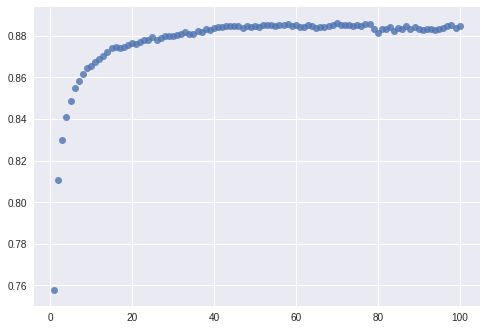

In [163]:
sns.regplot(x=PF['x'], y=np.array(PF['Perceptron']), fit_reg=False)
sns.regplot(x=PF['x'], y=np.array(PF['CNN (pytorch)']), fit_reg=False)
plt.show()

In [164]:
!pip install livelossplot

  Running setup.py bdist_wheel for livelossplot ... - \ done
  Stored in directory: /content/.cache/pip/wheels/67/8b/e9/3990164e3b2a421145b9d9d76fc8aa889225d495b043faeb73
Successfully built livelossplot
